# Parameter estimation: Spain
***

**Date**: 25-11-2024<br>

* [x] Add filter by degree of regulation
* [ ] Analyse parameter sensitivity in the model
* [x] Simulate the model with the estimated parameters
* [ ] MLP in `scikitlearn`
* [ ] Increase range in the calibration of $\delta$
* [ ] Use `XGBoost` instead of `scikit-learn` to be able to use the GPU
* [ ] Give more attention to the use attributes!

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pickle

In [2]:
from reservoirs_lshm import read_attributes#, read_timeseries
from reservoirs_lshm.models import get_model
from reservoirs_lshm.utils.metrics import compute_performance

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## 1 Configuration

In [4]:
country = 'ES'
version = 'v3.0'
reservoir_model = 'hanazaki_2pars'

data_dir = Path(f'/eos/jeodpp/home/users/casadje/data/ResOps{country}')
results_dir = Path(f'./results/{country}/')
results_dir.mkdir(parents=True, exist_ok=True)

paths_runs = {
    'default': data_dir / 'results' / reservoir_model / 'default',
    'storage': data_dir / 'results' / reservoir_model / 'calibration' / 'storage',
    'outflow': data_dir / 'results' / reservoir_model / 'calibration' / 'outflow',
    'bivariate': data_dir / 'results' / reservoir_model / 'calibration' / 'bivariate'
}

par_range ={
    'alpha': (0.2, 0.99),
    'beta': (0.001, 0.999), 
    'gamma': (0.001, 0.999),
    'delta': (0.1, 0.5),
    'epsilon': (0.001, 0.999),
}

metric = 'KGE'

## 2 Data

### Attributes

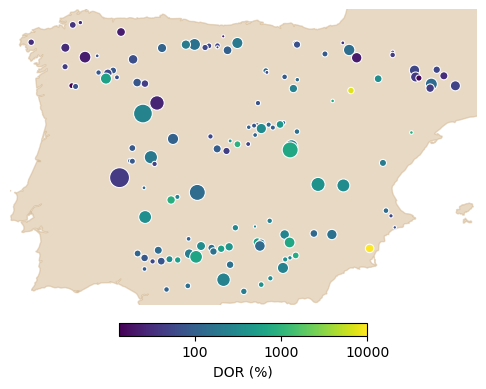

In [5]:
# load attributes
attributes = read_attributes(
    path=data_dir / version / 'attributes',
    reservoirs=pd.read_csv(data_dir / version / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()
)
attributes.columns = attributes.columns.str.lower()

# convert into geopandas
attributes = gpd.GeoDataFrame(
    attributes,
    geometry=[Point(xy) for xy in zip(attributes['lon'], attributes['lat'])],
    crs='epsg:4326'
)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
sct = ax.scatter(
    attributes.lon,
    attributes.lat,
    s=attributes.cap_mcm**.66,
    c=np.log10(attributes.dor_pc),
    cmap='viridis',
    edgecolor='w',
    lw=.75)
cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)
cbar.set_label('DOR (%)')
xticks = [2, 3, 4]
cbar.set_ticks(xticks)
cbar.set_ticklabels(np.power(10, xticks))
ax.axis('off');

### Time series

In [6]:
# read periods
with open(data_dir / version / 'selection' / 'periods.pkl', 'rb') as file:
    periods = pickle.load(file)

# read time series
timeseries = {}
for file in (data_dir / version / 'time_series').glob('*.nc'):
    ID = file.stem
    if ID in periods:
        ds = xr.open_dataset(file)[['storage', 'inflow', 'outflow']]
        start, end = [periods[ID][f'{x}_dates'][0] for x in ['start', 'end']]
        df = ds.sel(date=slice(start, end)).to_pandas()
        df.storage *= 1e6
        timeseries[int(ID)] = df

### Runs

In [7]:
results = []
for run, path in paths_runs.items():
    # optimal parameters
    parameters = pd.DataFrame(dtype=float)
    if run == 'default':
        # default reservoir limits
        limits_def = pd.DataFrame(dtype=float)
        for file in path.glob('*parameters.yml'):
            # reservoir ID
            ID = int(file.stem.split('_')[0])
            # extract alpha
            with open(file, 'r') as f:
                lims = yaml.safe_load(f)
            limits_def = pd.concat((limits_def, pd.DataFrame({ID: lims}).transpose()), axis=0)
            parameters.loc[ID, 'alpha'] = lims['Vf'] / lims['Vtot']
            if reservoir_model.endswith('5pars'):
                parameters.loc[ID, 'beta'] = (lims['Vtot'] - lims['Ve']) / (lims['Vtot'] - lims['Vf'])
                parameters.loc[ID, 'gamma'] = lims['Vmin'] / lims['Vf'] 
                parameters.loc[ID, 'epsilon'] = lims['Qn'] / lims['Qf']
        parameters['delta'] = 0.30
    else:
        for file in path.glob('*samples.csv'):
            # reservoir ID
            ID = int(file.stem.split('_')[0])
            # extract best sample from the calibration
            samples = pd.read_csv(file)
            mask_cols = samples.columns.str.startswith('par')
            parvalues = samples.loc[[samples.like1.idxmin()], mask_cols]
            parvalues.index = [ID]
            parvalues.index.name = 'ID'
            parvalues.rename(columns={col: col[3:] for col in parvalues.columns if col.startswith('par')}, inplace=True)
            parameters = pd.concat((parameters, parvalues), axis=0)
    parameters.index.name = 'ID'
    
    # performance
    performance = pd.DataFrame(dtype=float)
    for file in path.glob('*performance.csv'):
        # reservoir ID
        ID = int(file.stem.split('_')[0])
        # extract best sample from the calibration
        perf = pd.read_csv(file, index_col='metric')
        perf = perf.loc[[metric], ['storage', 'outflow']]
        perf.index = [ID]
        perf.index.name = 'ID'
        perf.columns = [f'{metric}_{col}' for col in perf.columns]
        performance = pd.concat((performance, perf), axis=0)

    # concat all results
    results.append(xr.Dataset(pd.concat((parameters, performance), axis=1)).expand_dims(dim={'run': [run]}))

# merge in a single Dataset
results = xr.merge(results)
results = results.reindex(run=['default', 'storage', 'outflow', 'bivariate'])

## 3 Analyse runs

In [8]:
path_analysis = paths_runs['default'].parent / 'plots'
path_analysis.mkdir(exist_ok=True)

### Correlation & distribution

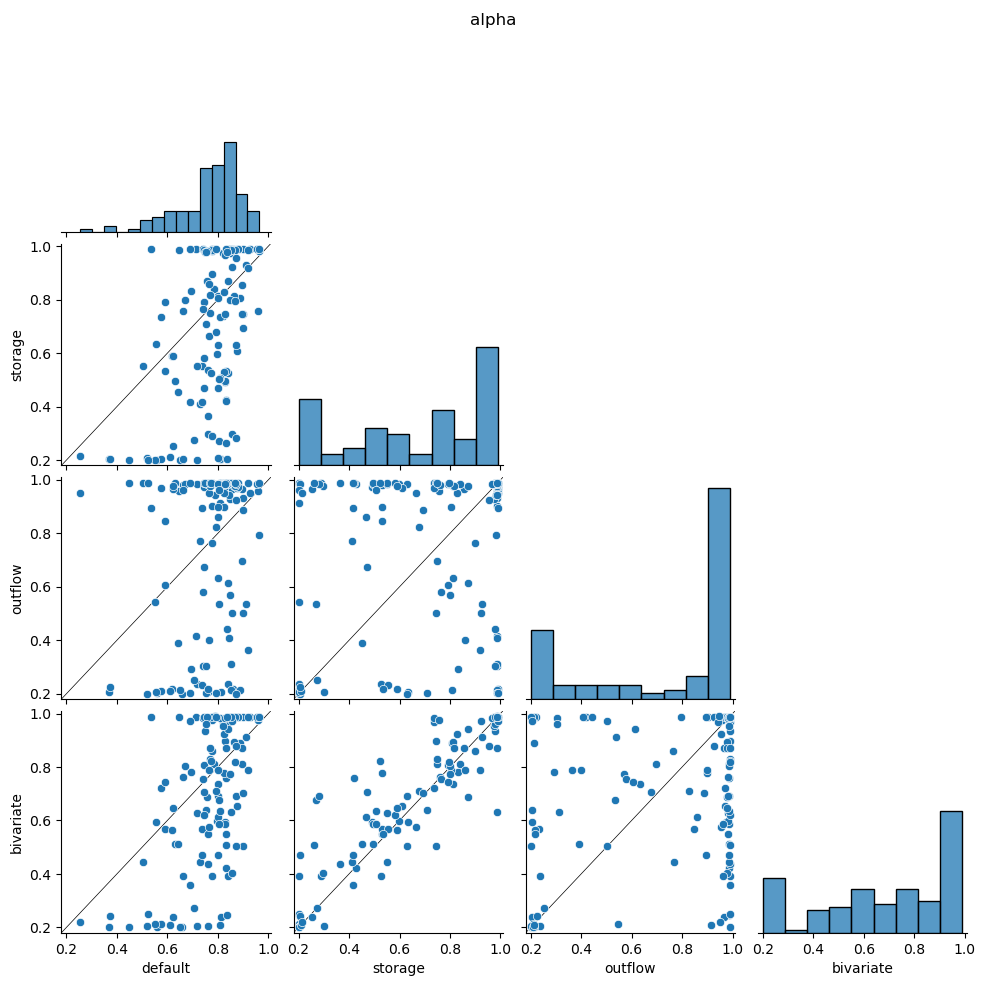

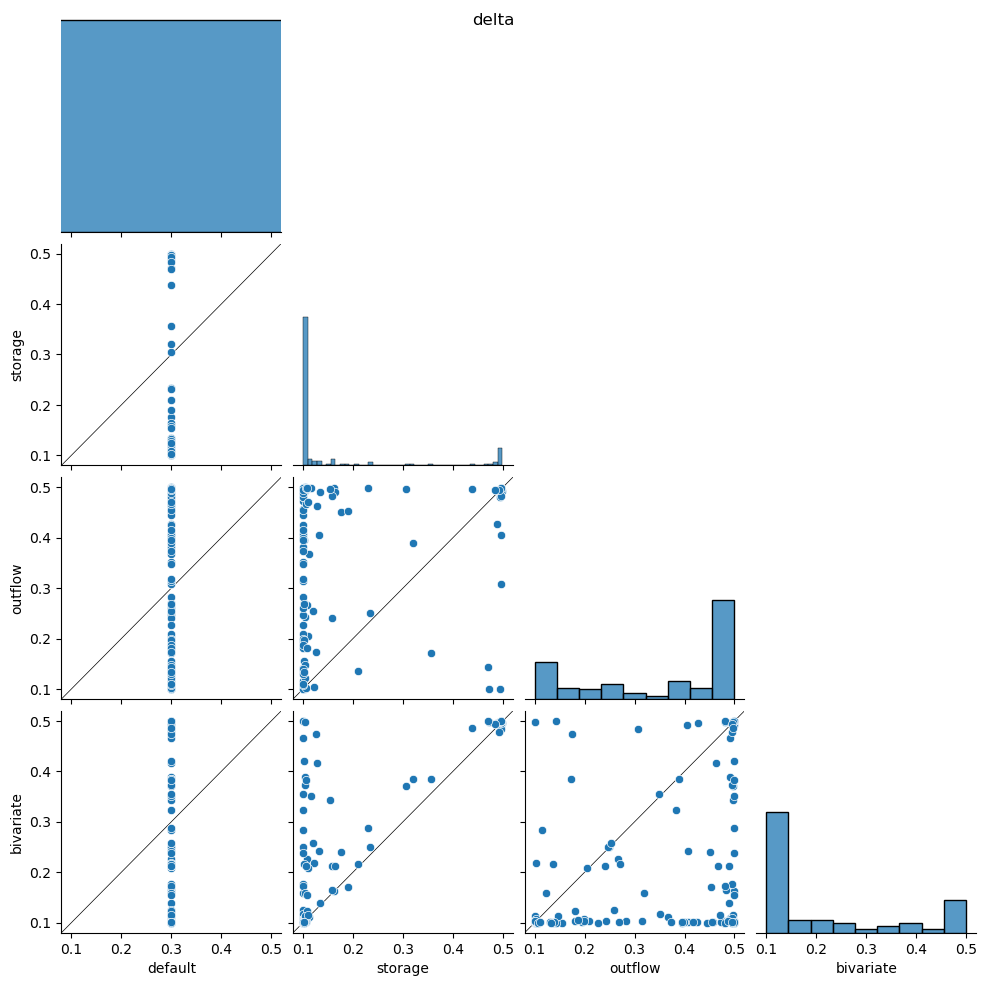

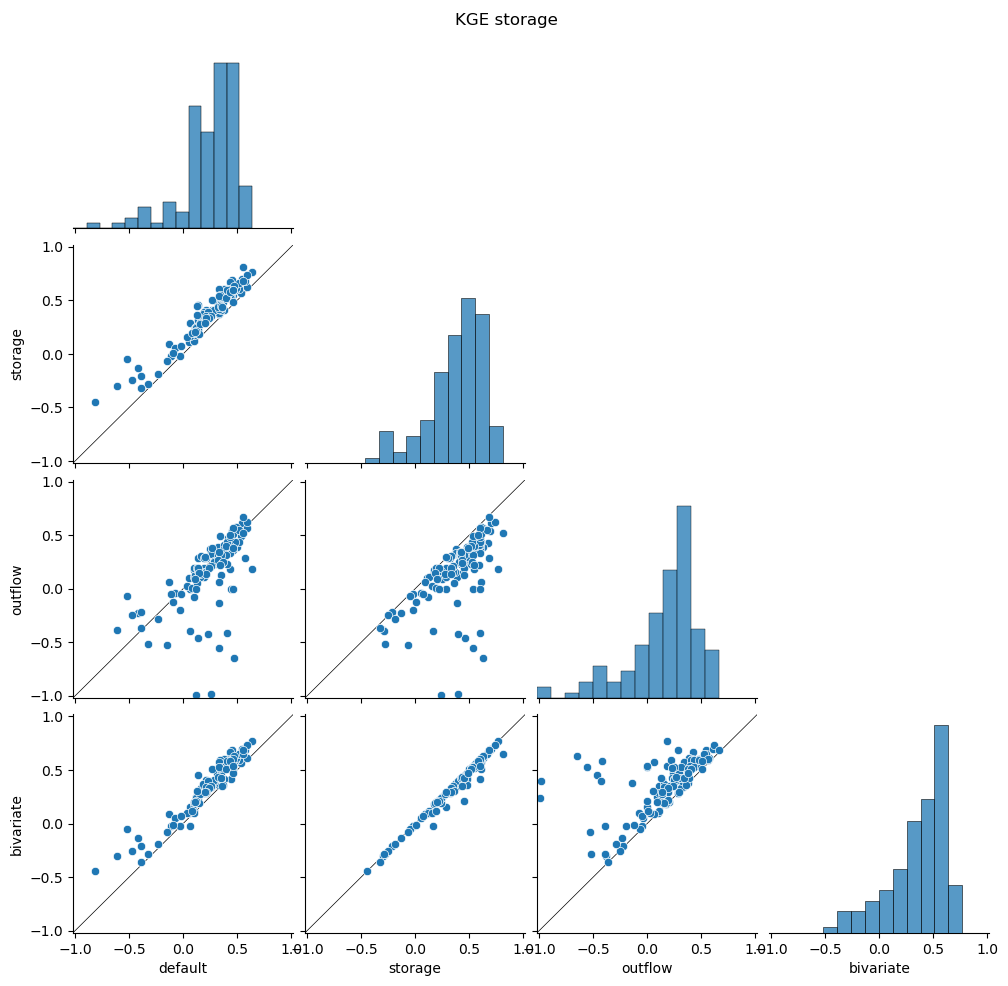

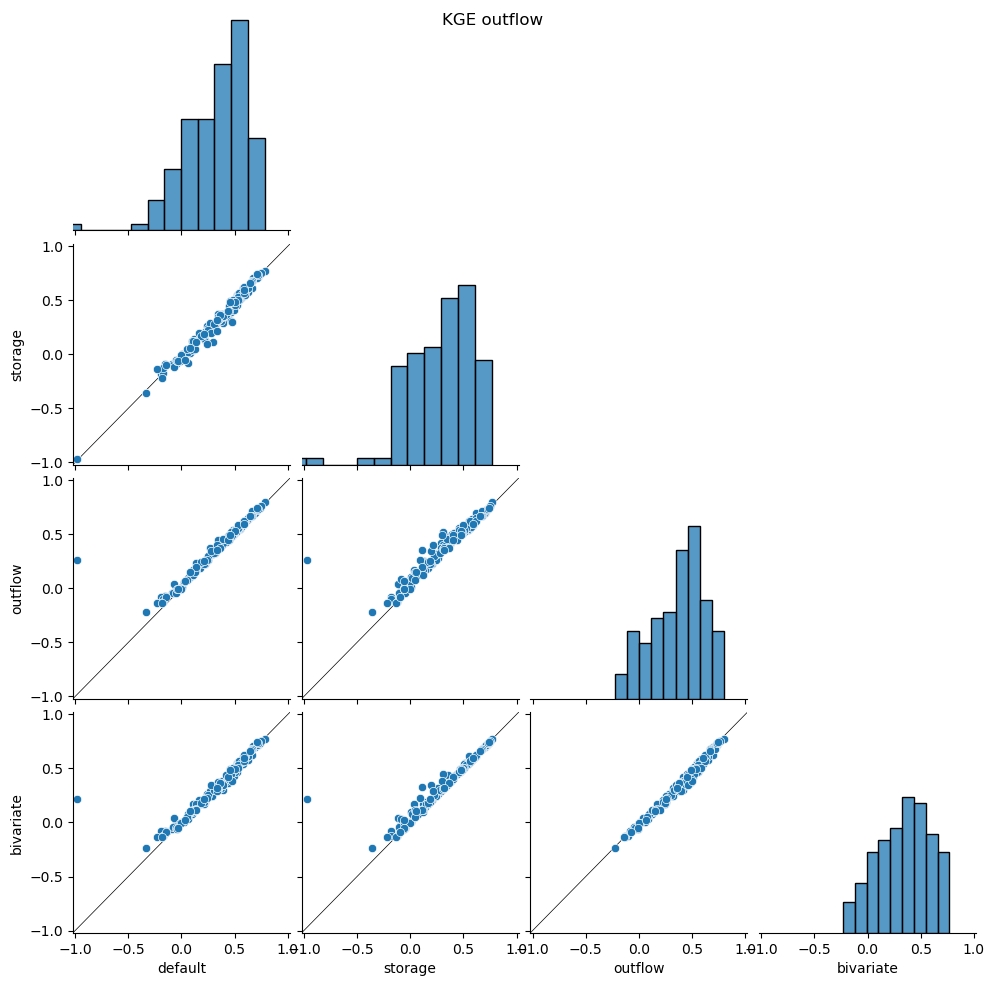

In [9]:
for par, da in results.items():
    pairplot = sns.pairplot(da.to_pandas().transpose(), corner=True)
    pairplot.fig.suptitle(' '.join(par.split('_')))
    if par.startswith('KGE'):
        vlim = (-1.02, 1.02)
    else:
        vlim = [v + e * .02 for v, e in zip(par_range[par], [-1, 1])]
    axes = pairplot.axes
    for i in range(1, axes.shape[0]):
        for j in range(0, axes.shape[1]):
            if j >= i:
                continue
            axes[i,j].plot(vlim, vlim, lw=.5, c='k', zorder=0)
    pairplot.set(
        xlim=vlim,
        ylim=vlim,
    )
    plt.savefig(path_analysis / f'{par}_pairplot.jpg', dpi=300, bbox_inches='tight')

### Geographical distribution

#### Performance

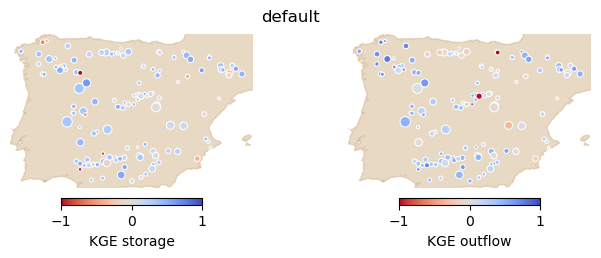

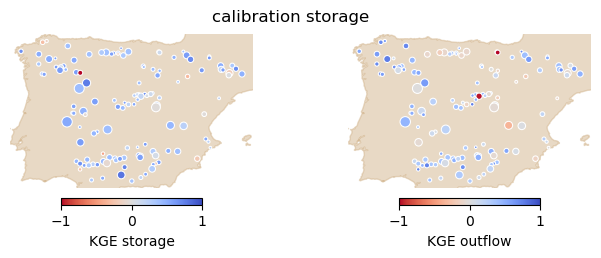

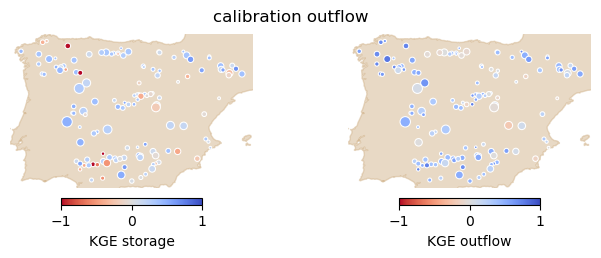

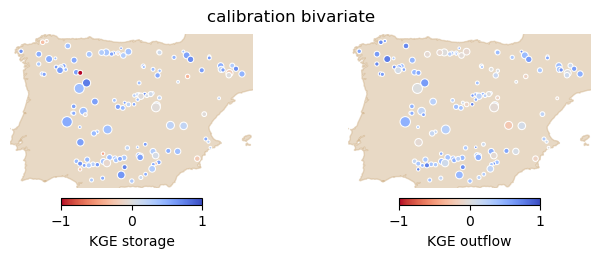

In [10]:
for run in results.run.data: 
    attributes.drop(['alpha', 'delta', 'KGE_storage', 'KGE_outflow'], axis=1, inplace=True, errors='ignore')

    df = results.sel(run=run).to_pandas().drop('run', axis=1)
    df.index.name = 'GRAND_ID'
    attributes = pd.concat((attributes, df), axis=1)

    fig, axes = plt.subplots(ncols=2, figsize=(8, 2.5), subplot_kw=dict(projection=ccrs.PlateCarree()))
    if run == 'default':
        fig.suptitle(run)
    else:
        fig.suptitle(f'calibration {run}')
    for ax, var in zip(axes, ['storage', 'outflow']):
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
        sct = ax.scatter(
            attributes.lon,
            attributes.lat,
            s=attributes.cap_mcm**.5,
            c=attributes[f'KGE_{var}'],
            edgecolor='w',
            lw=.75,
            cmap='coolwarm_r',
            norm=mcolors.Normalize(vmin=-1, vmax=1)
        )
        cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
        cbar.set_label(f'KGE {var}')
        ax.axis('off');
    plt.savefig(path_analysis / f'performance_maps_{run}.jpg', dpi=300, bbox_inches='tight')

#### Parameter values

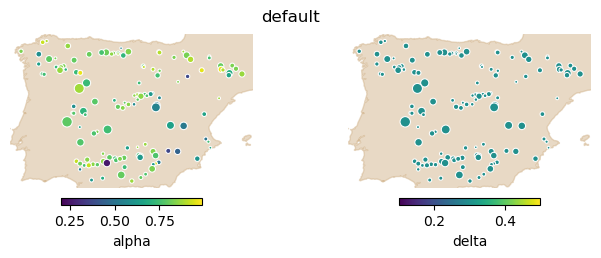

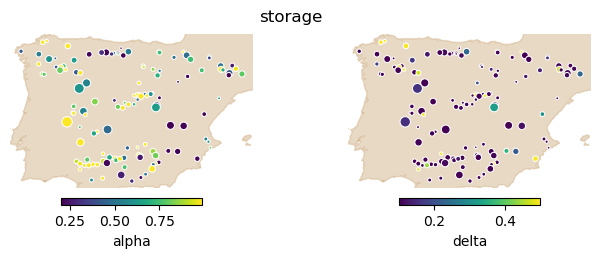

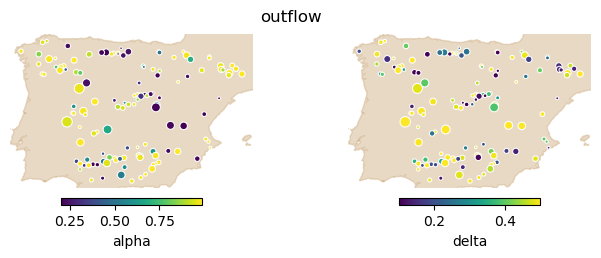

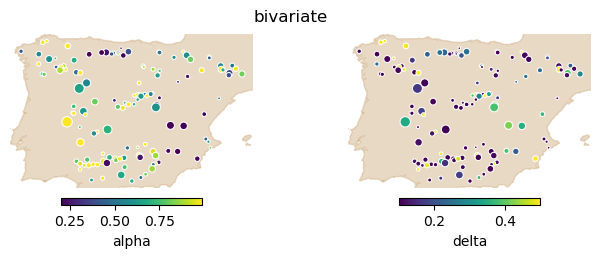

In [13]:
for run in results.run.data: 
    attributes.drop(['alpha', 'delta', 'KGE_storage', 'KGE_outflow'], axis=1, inplace=True, errors='ignore')

    df = results.sel(run=run).to_pandas().drop('run', axis=1)
    df.index.name = 'GRAND_ID'
    attributes = pd.concat((attributes, df), axis=1)

    fig, axes = plt.subplots(ncols=2, figsize=(8, 2.5), subplot_kw=dict(projection=ccrs.PlateCarree()))
    fig.suptitle(run)
    for ax, par in zip(axes, ['alpha', 'delta']):
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
        sct = ax.scatter(
            attributes.lon,
            attributes.lat,
            s=np.sqrt(attributes.cap_mcm),
            c=attributes[par],
            edgecolor='w',
            lw=.75,
            cmap='viridis',
            norm=mcolors.Normalize(*par_range[par])
        )
        cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
        cbar.set_label(par)
        ax.axis('off');
    plt.savefig(path_analysis / f'parameter_maps_{run}.jpg', dpi=300, bbox_inches='tight')

## Models

### Dataset

In [17]:
thr = 0.25
mask_storage = attributes.KGE_storage >= thr
mask_outflow = attributes.KGE_outflow >= thr
mask_dor = (attributes.dor_pc >= 8)
mask_storage.sum(), mask_outflow.sum(), mask_dor.sum(), (mask_storage & mask_outflow & mask_dor).sum()

(94, 83, 130, 68)

In [19]:
dataset = attributes[mask_storage & mask_outflow].copy()
features = ['temp_mean', 'pet_mean', 'precip_mean', 'snow_mean', 'aridity', 'frac_snow',
           'moisture_index', 'seasonality', 'high_precip_freq', 'high_precip_dur', 'low_precip_freq', 'low_precip_dur',
           'area_skm', 'cap_mcm', 'catch_skm', 'dam_hgt_m', 'dam_len_m', 'depth_m', 'dis_avg_ls', 'dor_pc', 'elev_masl',
            'hydropower', 'flood', 'fish', 'irrigation', 'livestock', 'navigation', 'other_use', 'pollution', 'recreation','supply',
            #'use_elec', 'use_fcon', 'use_fish', 'use_irri', 'use_live', 'use_navi', 'use_othr', 'use_pcon', 'use_recr', 'use_supp',
           'lat', 'lon',]
targets  = ['alpha', 'delta']

X, y = dataset[features], dataset[targets]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape

((47, 33), (47, 2))

### Median

In [ ]:
# y_pred = np.median(y_train, axis=0) * len(y_test)
# print('RMSE = {0:.3f}'.format(root_mean_squared_error(y_test, y_pred)))

### Linear regression

In [ ]:
# lr = LinearRegression().fit(X_train, y_train)
# y_pred = lr.predict(X_test)
# print('RMSE = {0:.3f}'.format(root_mean_squared_error(y_test, y_pred)))

### Random forest univariate

In [20]:
path_rf1 = results_dir / 'random_forest_1'
path_rf1.mkdir(exist_ok=True)

#### Fit model

In [21]:
param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    # verbose=2
)
rf1 = {}
for par in y_train.columns:
    grid_search.fit(X_train, y_train[par])
    model = grid_search.best_estimator_
    print(grid_search.best_params_)
    y_pred = pd.Series(model.predict(X_test), index=X_test.index, name=par)
    rmse = root_mean_squared_error(y_test[par], y_pred)
    print(f'RMSE ({par}) = {rmse:.3f}')
    rf1[par] = model
    # export
    with open(path_rf1 / f'random_forest_{par}.pkl', 'wb') as file:
        pickle.dump(model, file)
y_rf1 = pd.DataFrame({par: pd.Series(model.predict(X), index=X.index) for par, model in rf1.items()})

RMSE (alpha) = 0.266
RMSE (delta) = 0.141


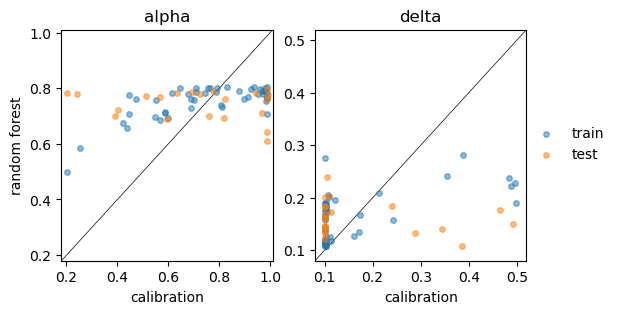

In [23]:
ncols = len(targets)
fig, axes = plt.subplots(ncols=ncols, figsize=(3 * ncols, 3))
for ax, par in zip(axes, targets):
    ax.scatter(
        y_train[par],
        y_rf1.loc[X_train.index, par],
        c='C0',
        s=16,
        alpha=.5,
        label='train'
    )
    ax.scatter(
        y_test[par],
        y_rf1.loc[X_test.index, par],
        c='C1',
        s=16,
        alpha=.5,
        label='test'
    )
    vlim = [x + e for x, e in zip(par_range[par], [-.02, .02])]
    ax.plot(vlim, vlim, lw=.5, c='k', zorder=0)
    ax.set(
        xlim=vlim,
        xlabel='calibration',
        ylim=vlim,
        title=par
    )
    if ax == axes[0]:
        ax.set_ylabel('random forest')
        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .3, .1, .3]);

plt.savefig(path_rf1 / 'parameter_scatter.jpg', dpi=300, bbox_inches='tight')

The correlation is almost inexistent!!

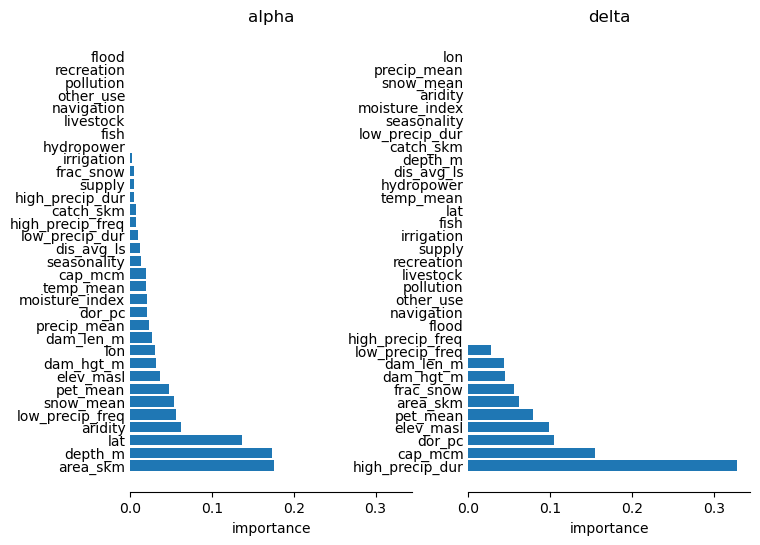

In [24]:
importance_rf1 = pd.DataFrame({par: pd.Series(model.feature_importances_, index=model.feature_names_in_) for par, model in rf1.items()})

fig, axes = plt.subplots(ncols=2, figsize=(8, 6), sharex=True)
for ax, par in zip(axes, targets):
    imp = importance_rf1[par].sort_values(ascending=False)
    ax.barh(imp.index, imp)
    ax.set(
        xlabel='importance',
        title=par
    )
    ax.tick_params(axis='y', length=0)
    ax.spines[['left', 'top', 'right']].set_visible(False)
    
plt.savefig(path_rf1 / 'importance_bar.jpg', dpi=300, bbox_inches='tight')

#### Simulate reservoirs

In [50]:
# adapt limits based on the estimation
limits_rf1 = limits_def.loc[X.index].copy()
limits_rf1.Vf = limits_rf1.Vtot * y_rf1['alpha']
limits_rf1.Vmin = limits_rf1.Vf * .5
limits_rf1.Ve = limits_rf1.Vtot - .2 * (limits_rf1.Vtot - limits_rf1.Vf)
limits_rf1.Qf *= y_rf1['delta'] / 0.3

performance_rf1 = pd.DataFrame(columns=['storage', 'outflow'])
for ID, row in limits_rf1.iterrows():
    
    # declare reservoir
    attrs = {attr: row[attr] for attr in ['Vmin', 'Vf', 'Ve', 'Vtot', 'Qn', 'Qf']}
    attrs.update({'A': attributes.loc[ID, 'catch_skm'] * 1e6})
    res = get_model('Hanazaki', **attrs)

    # simulate
    obs = timeseries[ID]
    sim = res.simulate(
        inflow=obs.inflow,
        Vo=obs.storage.iloc[0],
    )

    # analyse performance
    perf = compute_performance(timeseries[ID], sim)
    performance_rf1.loc[ID, :] = perf.loc[metric, performance_rf1.columns].values

# performance_rf1.index.name = 'ID'
performance_rf1.columns = [f'{metric}_{var}' for var in performance_rf1.columns]

In [54]:
# add to the calibration results
results_rf1 = pd.concat((y_rf1, performance_rf1), axis=1)
results_rf1.index.name = 'ID'
results = xr.concat((results, xr.Dataset({col: results_rf1[col] for col in results_rf1.columns}).expand_dims({'run': ['random_forest_1']})), dim='run')

In [63]:
# performance of the best calibration
run = 'bivariate'
performance_cal = results.sel(ID=X.index, run=run)[['KGE_storage', 'KGE_outflow']].to_pandas().drop('run', axis=1)
# performance_cal.rename(columns={col: col.split('_')[-1] for col in performance_cal.columns}, inplace=True)

In [64]:
# performance of the default parameters
run = 'default'
performance_def = results.sel(ID=X.index, run=run)[['KGE_storage', 'KGE_outflow']].to_pandas().drop('run', axis=1)
# performance_def.rename(columns={col: col.split('_')[-1] for col in performance_def.columns}, inplace=True)

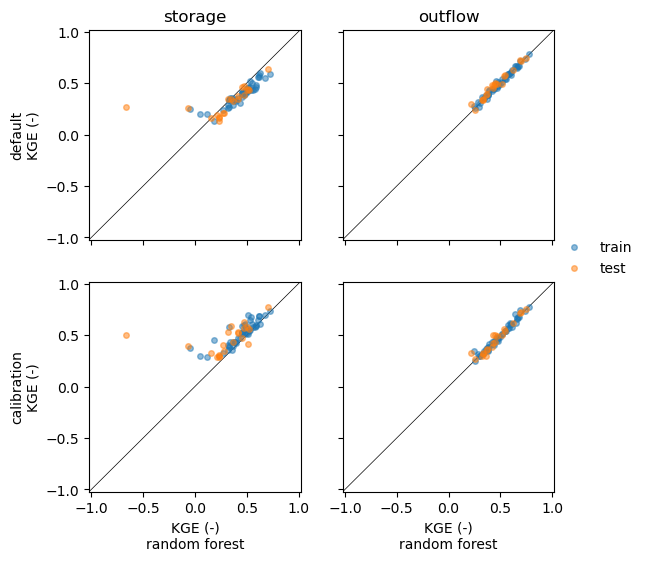

In [87]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6), sharex=True, sharey=True)
vlim = (-1.02, 1.02)
ax[0, 0].set(
    xlim=vlim,
    ylim=vlim,
)
for j, var in enumerate(['storage', 'outflow']):
    col = f'{metric}_{var}'
    ax[0, j].scatter(performance_rf1.loc[X_train.index, col], performance_def.loc[X_train.index, col], c='C0', s=16, alpha=.5, label='train')
    ax[0, j].scatter(performance_rf1.loc[X_test.index, col], performance_def.loc[X_test.index, col], c='C1', s=16, alpha=.5, label='test')
    ax[0, j].plot(vlim, vlim, c='k', lw=.5, zorder=0)
    ax[0, j].set_title(var)
    
    ax[1, j].scatter(performance_rf1.loc[X_train.index, col], performance_cal.loc[X_train.index, col], c='C0', s=16, alpha=.5, label='train')
    ax[1, j].scatter(performance_rf1.loc[X_test.index, col], performance_cal.loc[X_test.index, col], c='C1', s=16, alpha=.5, label='test')
    ax[1, j].plot(vlim, vlim, c='k', lw=.5, zorder=0)
    ax[1, j].set_xlabel('KGE (-)\nrandom forest')
    
    if j == 0:
        ax[0,j].set_ylabel('default\nKGE (-)')
        ax[1,j].set_ylabel('calibration\nKGE (-)')
        
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .25, .1, .3]);

plt.savefig(path_rf1 / 'performance_scatter.jpg', dpi=300, bbox_inches='tight')

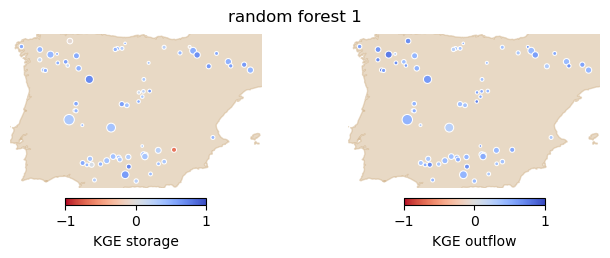

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 2.5), subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.suptitle('random forest 1')
for ax, var in zip(axes, ['storage', 'outflow']):
    col = f'{metric}_{var}'
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='tan'), alpha=.5, zorder=0)
    sct = ax.scatter(
        attributes.loc[y.index, 'lon'],
        attributes.loc[y.index, 'lat'],
        s=np.sqrt(attributes.loc[y.index, 'cap_mcm']),
        c=performance_rf1[col],
        edgecolor='w',
        lw=.75,
        cmap='coolwarm_r',
        norm=mcolors.Normalize(vmin=-1, vmax=1)
    )
    cbar = plt.colorbar(sct, orientation='horizontal', pad=.05, shrink=.5)#, ax=ax)
    cbar.set_label(f'{metric} {var}')
    ax.axis('off');
plt.savefig(path_rf1 / 'performance_maps.jpg', dpi=300, bbox_inches='tight')

### Random forest bivariate

In [76]:
path_rf2 = results_dir / 'random_forest_2'
path_rf2.mkdir(exist_ok=True)

#### Fit model 

In [78]:
# param_grid = {
#     'n_estimators': [10, 100, 1000],
#     'max_depth': [None, 1, 5, 10],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 4, 6]
# }
# grid_search = GridSearchCV(
#     RandomForestRegressor(random_state=42),
#     param_grid,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     n_jobs=-1,
#     # verbose=2
# )

# fit a model that predicts both parameters with the same settings
grid_search.fit(X_train, y_train)
rf2 = grid_search.best_estimator_
print(grid_search.best_params_)
with open(path_rf2 / f'random_forest_2par.pkl', 'wb') as file:
        pickle.dump(rf2, file)

# error
y_pred = pd.DataFrame(rf2.predict(X_test), index=X_test.index, columns=targets)
rmse = {var: root_mean_squared_error(y_test[var], y_pred[var]) for var in y_pred.columns}
for key, value in rmse.items():
    print(f'RMSE ({key}) = {value:.3f}')
# prediction for all samples
y_rf2 = pd.DataFrame(rf2.predict(X), index=X.index, columns=y.columns)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
RMSE (alpha) = 0.276
RMSE (delta) = 0.131


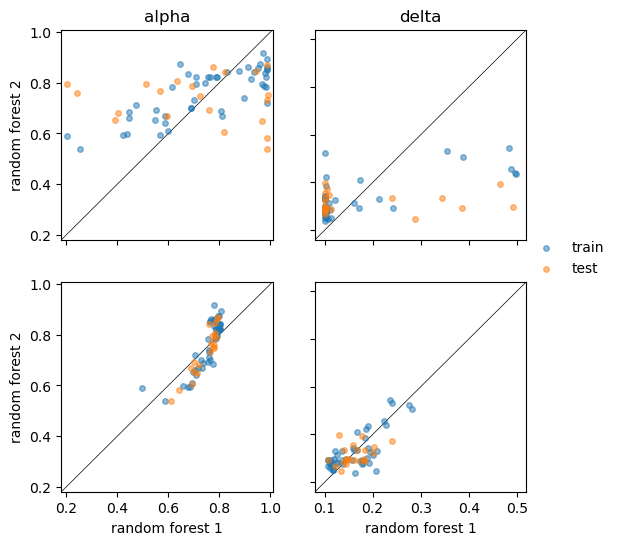

In [81]:
ncols = len(targets)
fig, axes = plt.subplots(ncols=ncols, nrows=2, figsize=(3 * ncols, 6))
for i, (label, df) in enumerate({'calibration': y, 'random forest 1': y_rf1}.items()):
    for j, par in enumerate(targets):
        axes[i,j].scatter(
            df.loc[X_train.index, par],
            y_rf2.loc[X_train.index, par],
            c='C0',
            s=16,
            alpha=.5,
            label='train'
        )
        axes[i,j].scatter(
            df.loc[X_test.index, par],
            y_rf2.loc[X_test.index, par],
            c='C1',
            s=16,
            alpha=.5,
            label='test'
        )
        vlim = [x + e for x, e in zip(par_range[par], [-.02, .02])]
        axes[i,j].plot(vlim, vlim, lw=.5, c='k', zorder=0)
        axes[i,j].set(
            xlim=vlim,
            ylim=vlim,
        )
        if i == 0:
            axes[0,j].set_title(par)
            axes[0,j].set_xticklabels([])
        elif i == 1:
            axes[1,j].set_xlabel(label)
        if j == 0:
            axes[i,0].set_ylabel('random forest 2')
        else:
            axes[i,j].set_yticklabels([])
        
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .25, .1, .3]);

plt.savefig(path_rf2 / 'parameter_scatter.jpg', dpi=300, bbox_inches='tight')

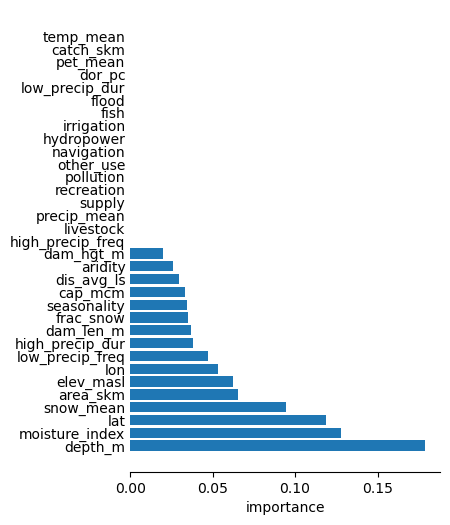

In [82]:
importance_rf2 = pd.Series(rf2.feature_importances_, index=rf2.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots(ncols=1, figsize=(4, 6), sharex=True)
ax.barh(importance_rf2.index, importance_rf2)
ax.set_xlabel('importance')
ax.tick_params(axis='y', length=0)
ax.spines[['left', 'top', 'right']].set_visible(False)

plt.savefig(path_rf2 / 'importance_bar.jpg', dpi=300, bbox_inches='tight')

#### Simulate reservoirs

In [83]:
# adapt limits based on the estimation
limits_rf2 = limits_def.loc[X.index].copy()
limits_rf2.Vf = limits_rf2.Vtot * y_rf2['alpha']
limits_rf2.Vmin = limits_rf2.Vf * .5
limits_rf2.Ve = limits_rf2.Vtot - .2 * (limits_rf2.Vtot - limits_rf2.Vf)
limits_rf2.Qf *= y_rf2['delta'] / 0.3

performance_rf2 = pd.DataFrame(columns=['storage', 'outflow'])
for ID, row in limits_rf2.iterrows():
    
    # declare reservoir
    attrs = {attr: row[attr] for attr in ['Vmin', 'Vf', 'Ve', 'Vtot', 'Qn', 'Qf']}
    attrs.update({'A': attributes.loc[ID, 'catch_skm'] * 1e6})
    res = get_model('Hanazaki', **attrs)

    # simulate
    obs = timeseries[ID]
    sim = res.simulate(
        inflow=obs.inflow,
        Vo=obs.storage.iloc[0],
    )

    # analyse performance
    perf = compute_performance(timeseries[ID], sim)
    performance_rf2.loc[ID, :] = perf.loc[metric, performance_rf2.columns].values
performance_rf2.columns = [f'{metric}_{var}' for var in performance_rf2.columns]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6116 [00:00<?, ?it/s]

  0%|          | 0/5084 [00:00<?, ?it/s]

  0%|          | 0/2099 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6116 [00:00<?, ?it/s]

  0%|          | 0/2902 [00:00<?, ?it/s]

  0%|          | 0/8737 [00:00<?, ?it/s]

  0%|          | 0/7880 [00:00<?, ?it/s]

  0%|          | 0/5478 [00:00<?, ?it/s]

  0%|          | 0/7822 [00:00<?, ?it/s]

  0%|          | 0/5687 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/5566 [00:00<?, ?it/s]

  0%|          | 0/9130 [00:00<?, ?it/s]

  0%|          | 0/5691 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/6208 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/11139 [00:00<?, ?it/s]

  0%|          | 0/9251 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/8012 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/8145 [00:00<?, ?it/s]

  0%|          | 0/5720 [00:00<?, ?it/s]

  0%|          | 0/9860 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9071 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/7154 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9254 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/8419 [00:00<?, ?it/s]

  0%|          | 0/9071 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9009 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/7154 [00:00<?, ?it/s]

  0%|          | 0/6271 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/9770 [00:00<?, ?it/s]

  0%|          | 0/11230 [00:00<?, ?it/s]

  0%|          | 0/2562 [00:00<?, ?it/s]

  0%|          | 0/5119 [00:00<?, ?it/s]

  0%|          | 0/4458 [00:00<?, ?it/s]

  0%|          | 0/2191 [00:00<?, ?it/s]

  0%|          | 0/2679 [00:00<?, ?it/s]

In [86]:
# add to the calibration results
results_rf2 = pd.concat((y_rf2, performance_rf2), axis=1)
results_rf2.index.name = 'ID'
results = xr.concat((results, xr.Dataset({col: results_rf2[col] for col in results_rf2.columns}).expand_dims({'run': ['random_forest_2']})), dim='run')

In [ ]:
# performance_cal = results.sel(ID=X.index, run='bivariate')[['KGE_storage', 'KGE_outflow']].to_pandas().drop('run', axis=1)
# performance_cal.rename(columns={col: col.split('_')[-1] for col in performance_cal.columns}, inplace=True)

In [ ]:
# performance_def = results.sel(ID=X.index, run='default')[['KGE_storage', 'KGE_outflow']].to_pandas().drop('run', axis=1)
# performance_def.rename(columns={col: col.split('_')[-1] for col in performance_def.columns}, inplace=True)

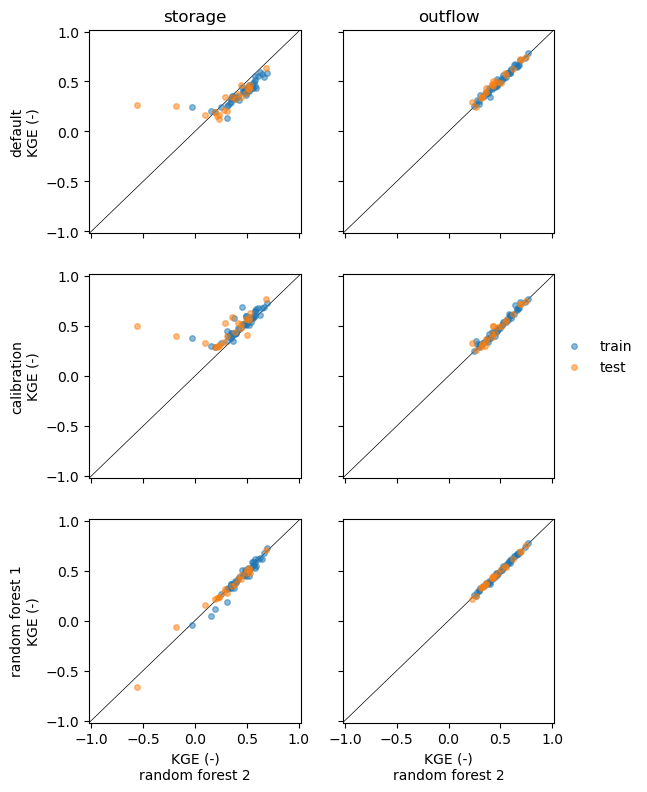

In [88]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(6, 9), sharex=True, sharey=True)
vlim = (-1.02, 1.02)
ax[0, 0].set(
    xlim=vlim,
    ylim=vlim,
)
for j, var in enumerate(['storage', 'outflow']):
    col = f'{metric}_{var}'
    ax[0, j].scatter(performance_rf2.loc[X_train.index, col], performance_def.loc[X_train.index, col], c='C0', s=16, alpha=.5, label='train')
    ax[0, j].scatter(performance_rf2.loc[X_test.index, col], performance_def.loc[X_test.index, col], c='C1', s=16, alpha=.5, label='test')
    ax[0, j].plot(vlim, vlim, c='k', lw=.5, zorder=0)
    ax[0, j].set_title(var)
    
    ax[1, j].scatter(performance_rf2.loc[X_train.index, col], performance_cal.loc[X_train.index, col], c='C0', s=16, alpha=.5, label='train')
    ax[1, j].scatter(performance_rf2.loc[X_test.index, col], performance_cal.loc[X_test.index, col], c='C1', s=16, alpha=.5, label='test')
    ax[1, j].plot(vlim, vlim, c='k', lw=.5, zorder=0)
    # ax[1, j].set_xlabel('KGE (-)\nrandom forest')
    
    ax[2, j].scatter(performance_rf2.loc[X_train.index, col], performance_rf1.loc[X_train.index, col], c='C0', s=16, alpha=.5, label='train')
    ax[2, j].scatter(performance_rf2.loc[X_test.index, col], performance_rf1.loc[X_test.index, col], c='C1', s=16, alpha=.5, label='test')
    ax[2, j].plot(vlim, vlim, c='k', lw=.5, zorder=0)
    ax[2, j].set_xlabel('KGE (-)\nrandom forest 2')
    
    if j == 0:
        ax[0,j].set_ylabel('default\nKGE (-)')
        ax[1,j].set_ylabel('calibration\nKGE (-)')
        ax[2,j].set_ylabel('random forest 1\nKGE (-)')
        
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, bbox_to_anchor=[.95, .25, .1, .3]);

plt.savefig(path_rf2 / 'performance_scatter.jpg', dpi=300, bbox_inches='tight')